# 1 Ramp 1x1x3

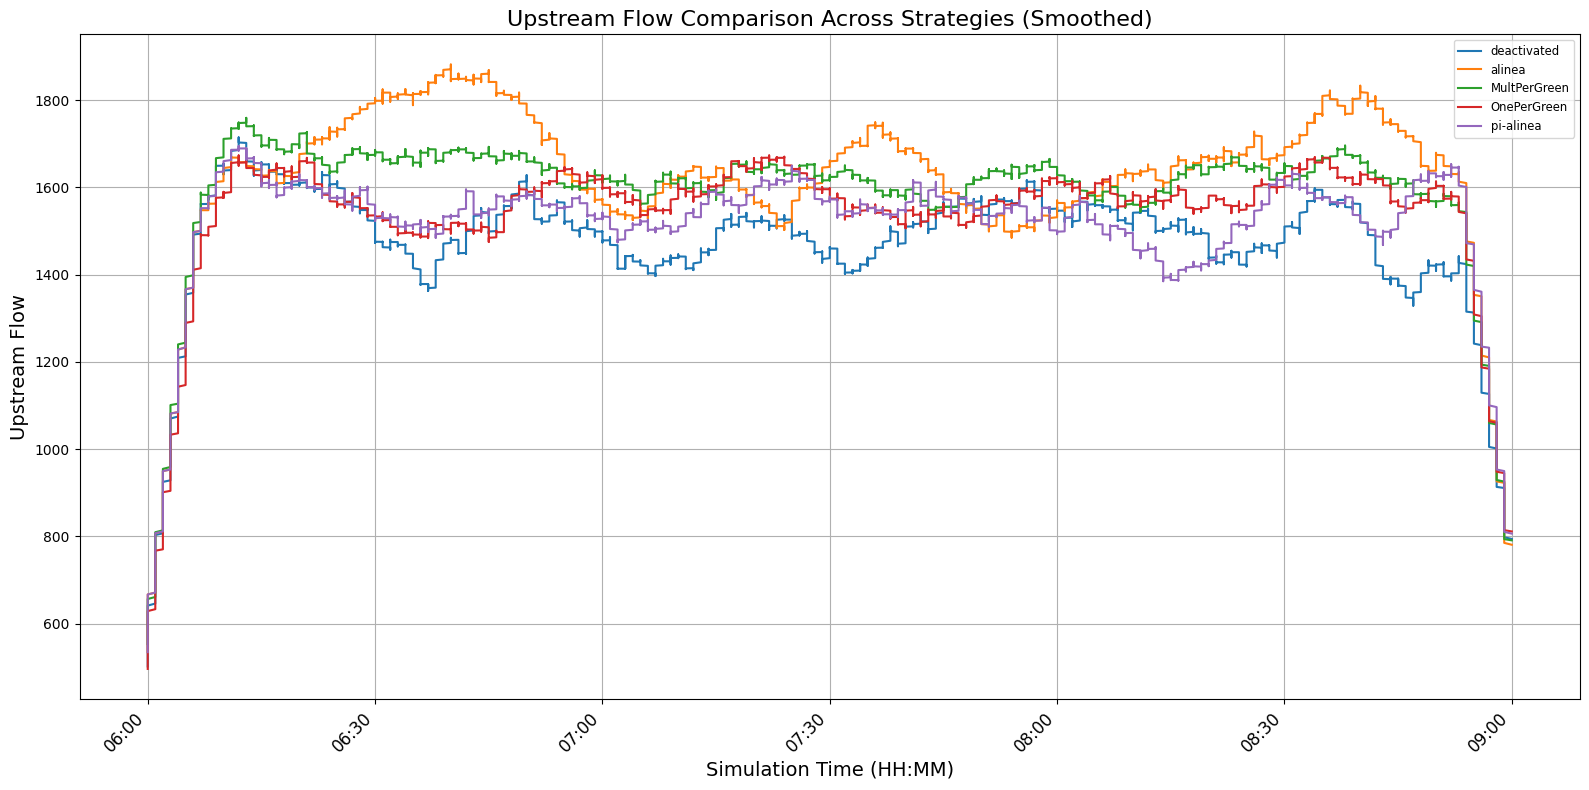

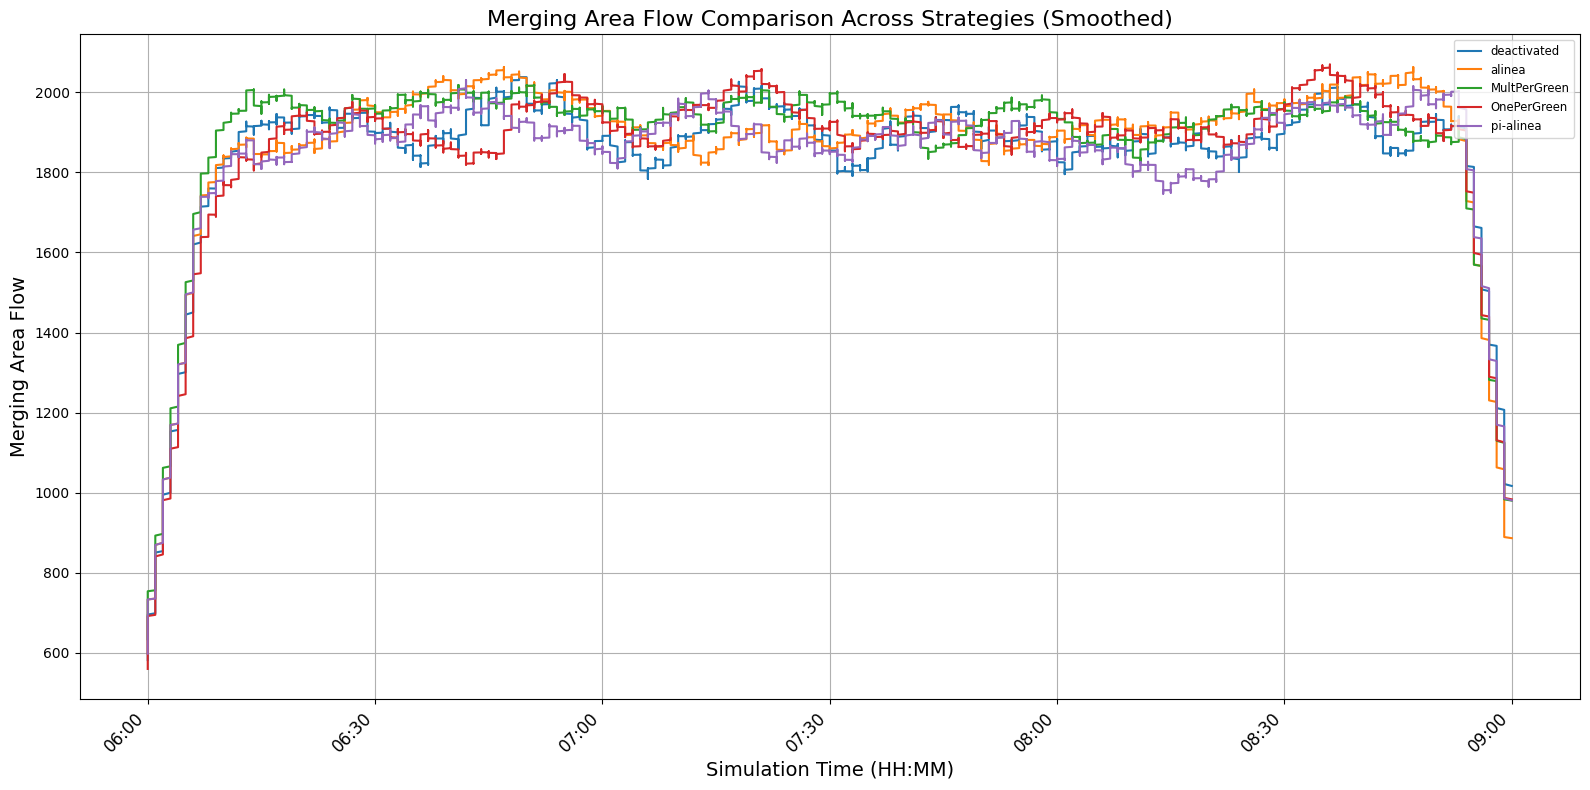

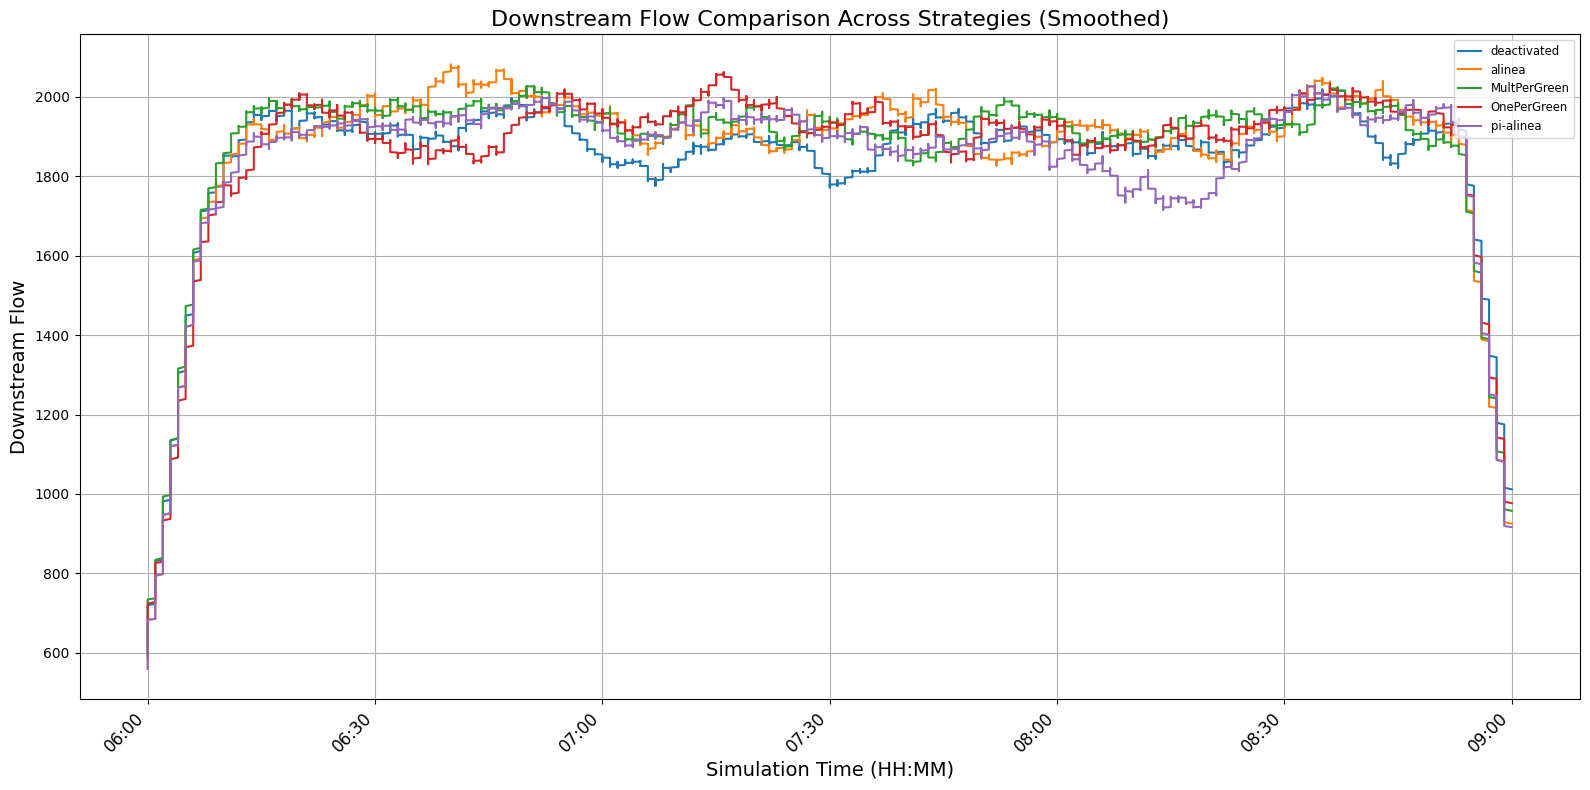

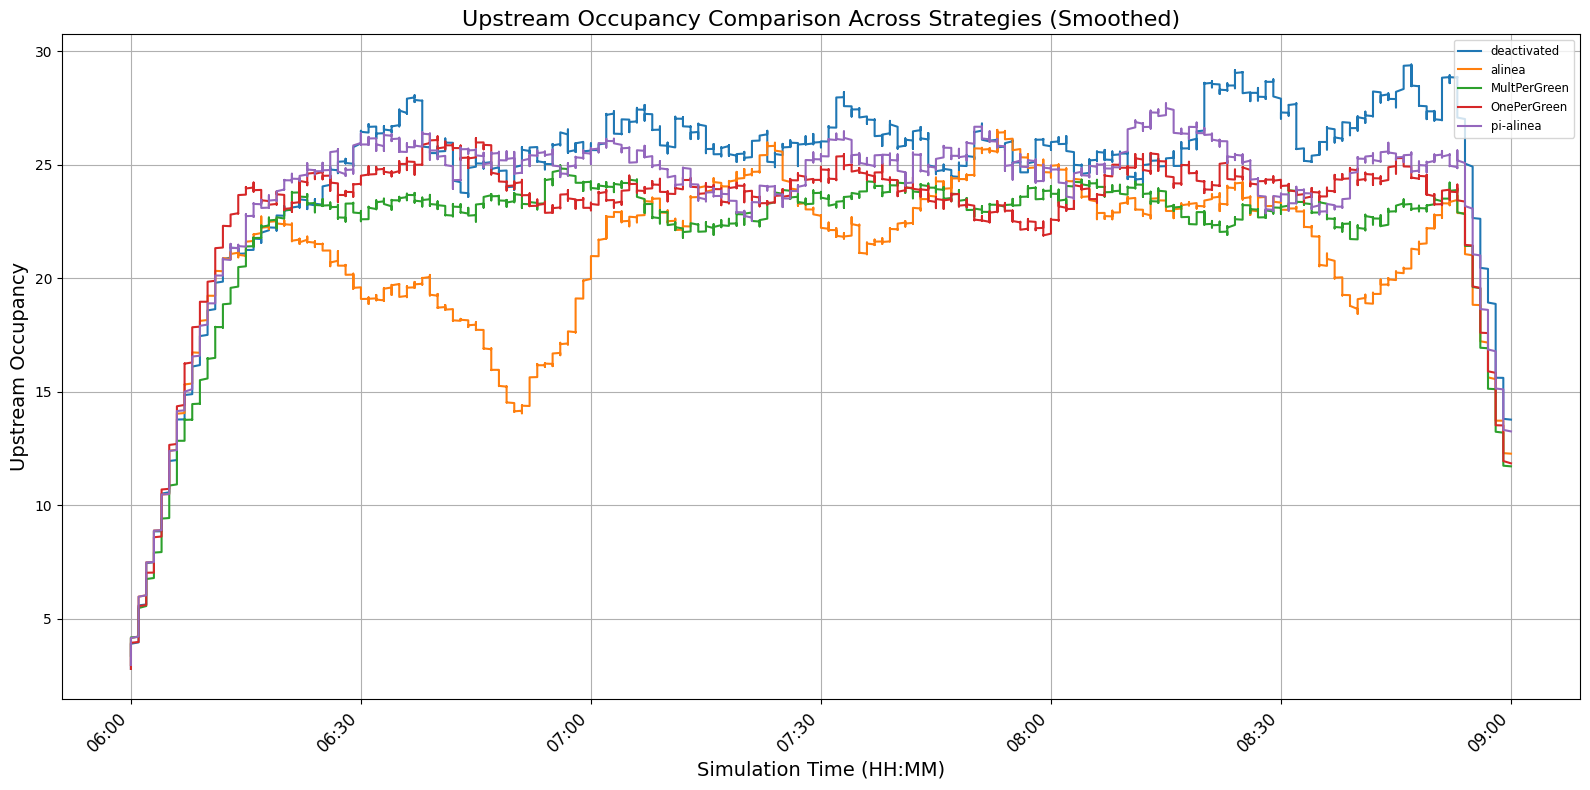

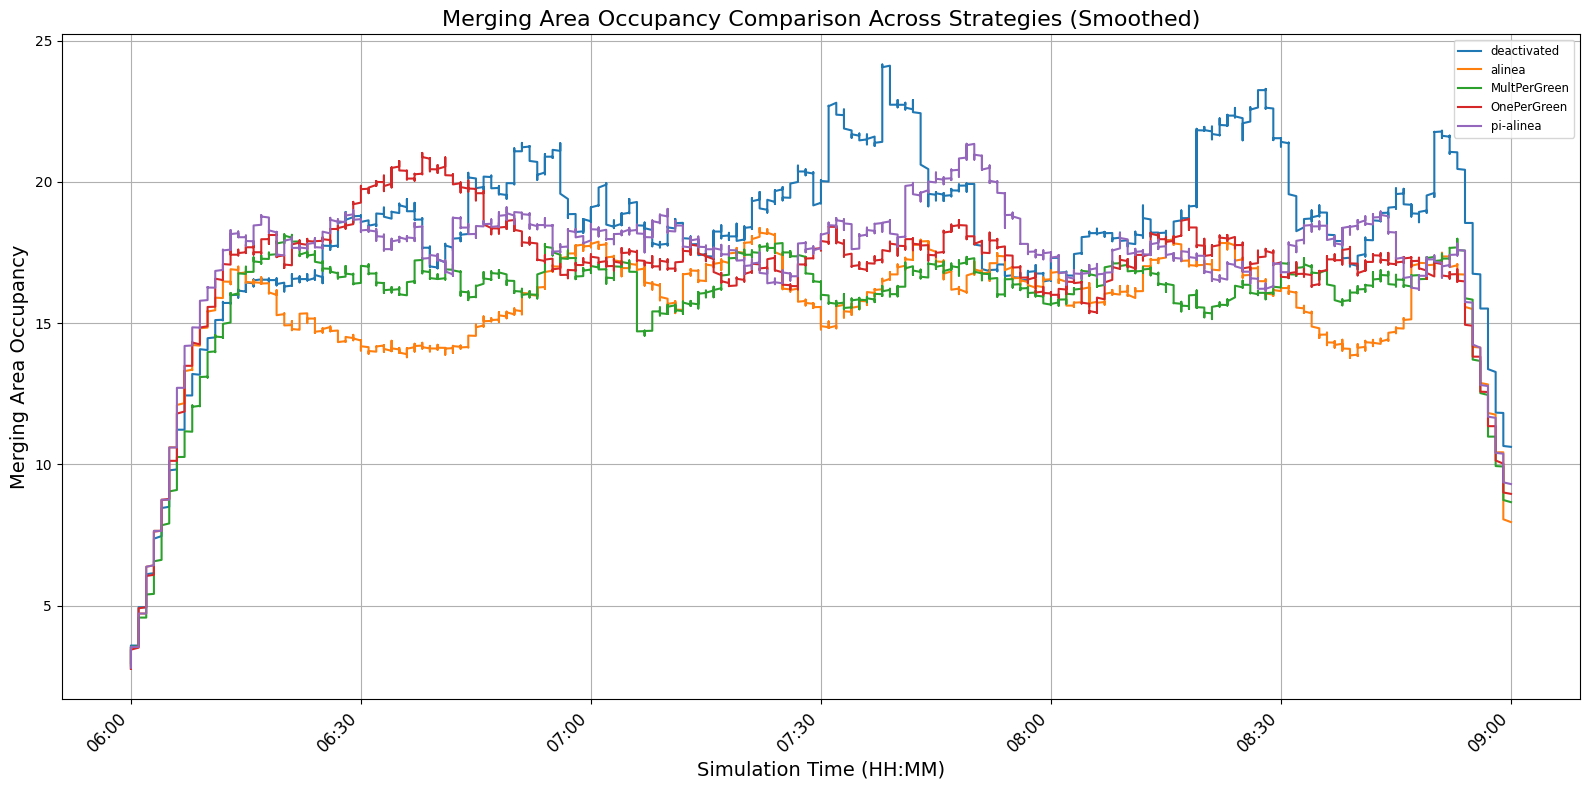

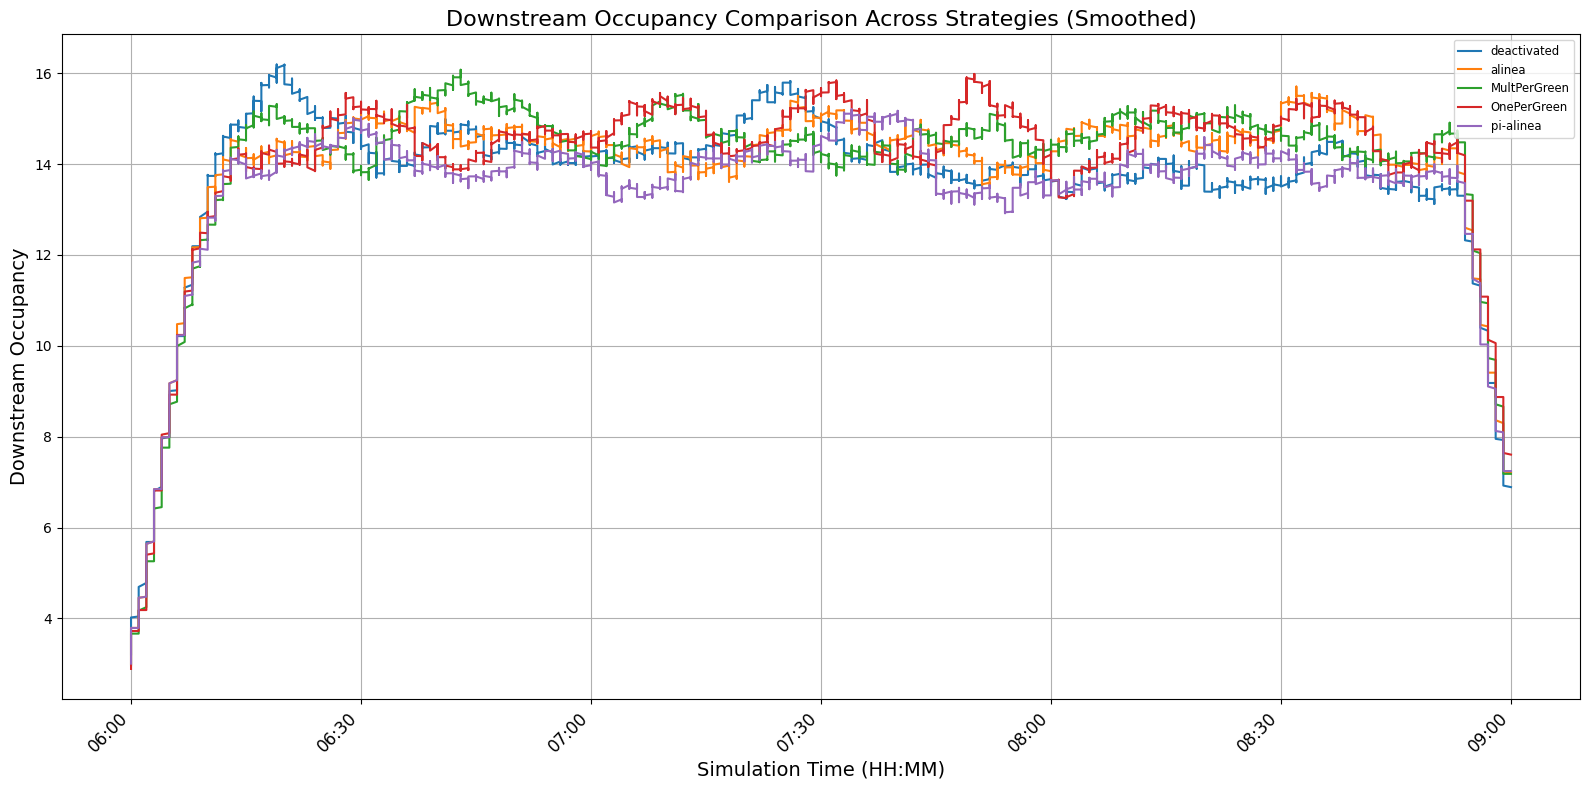

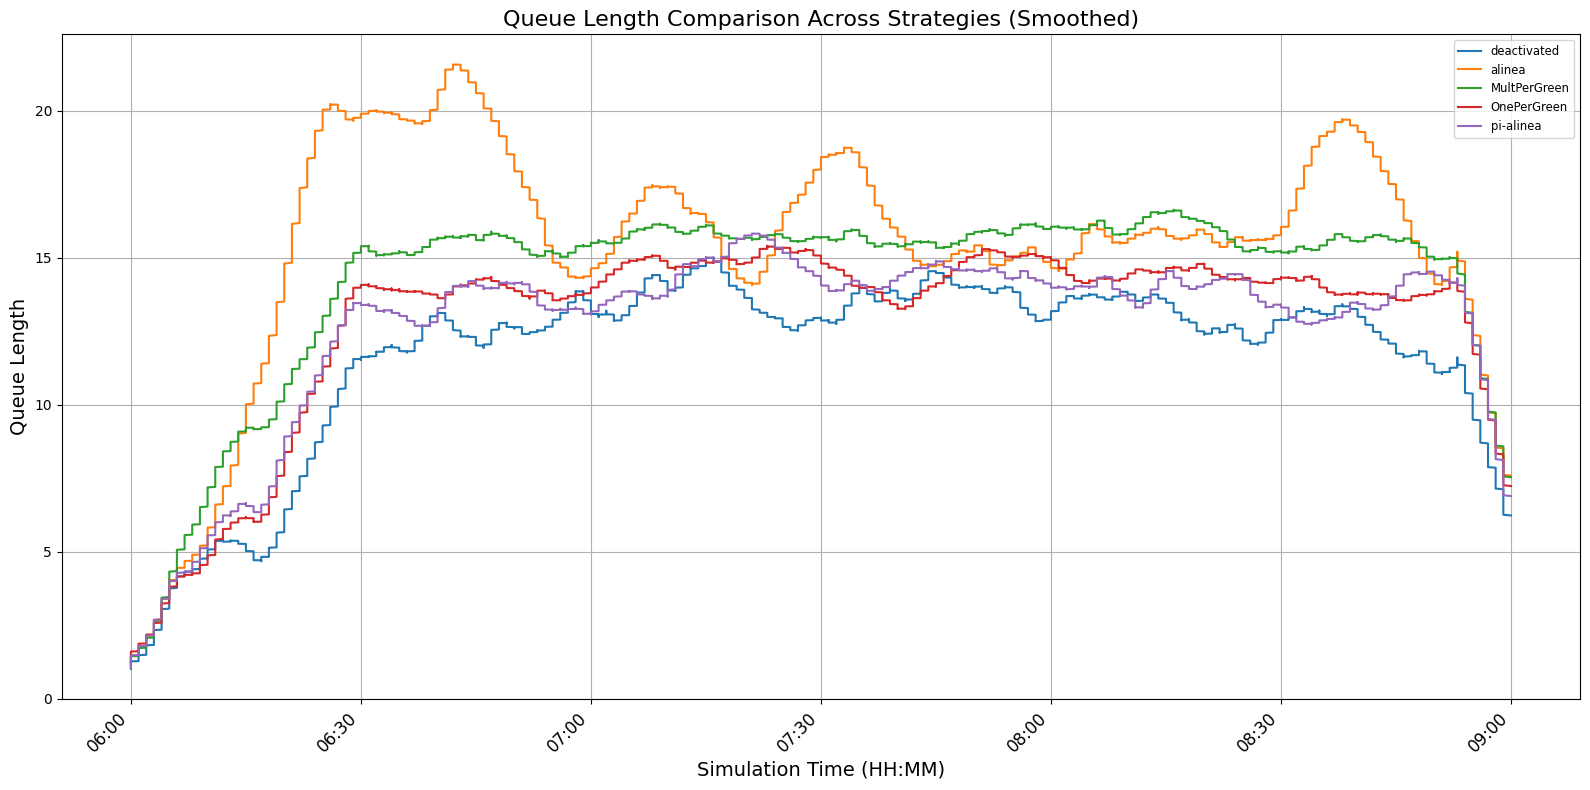

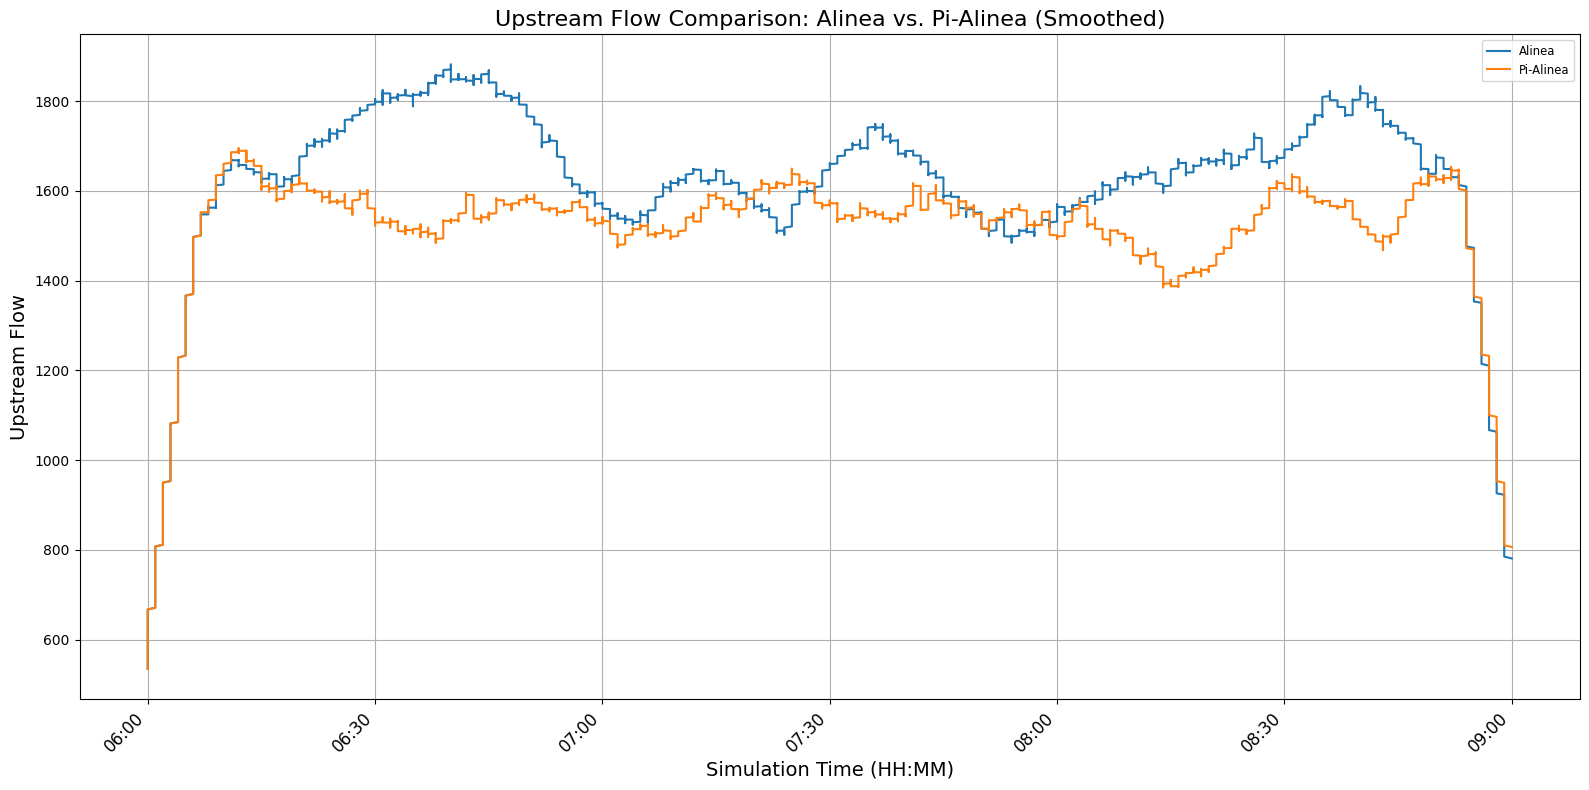

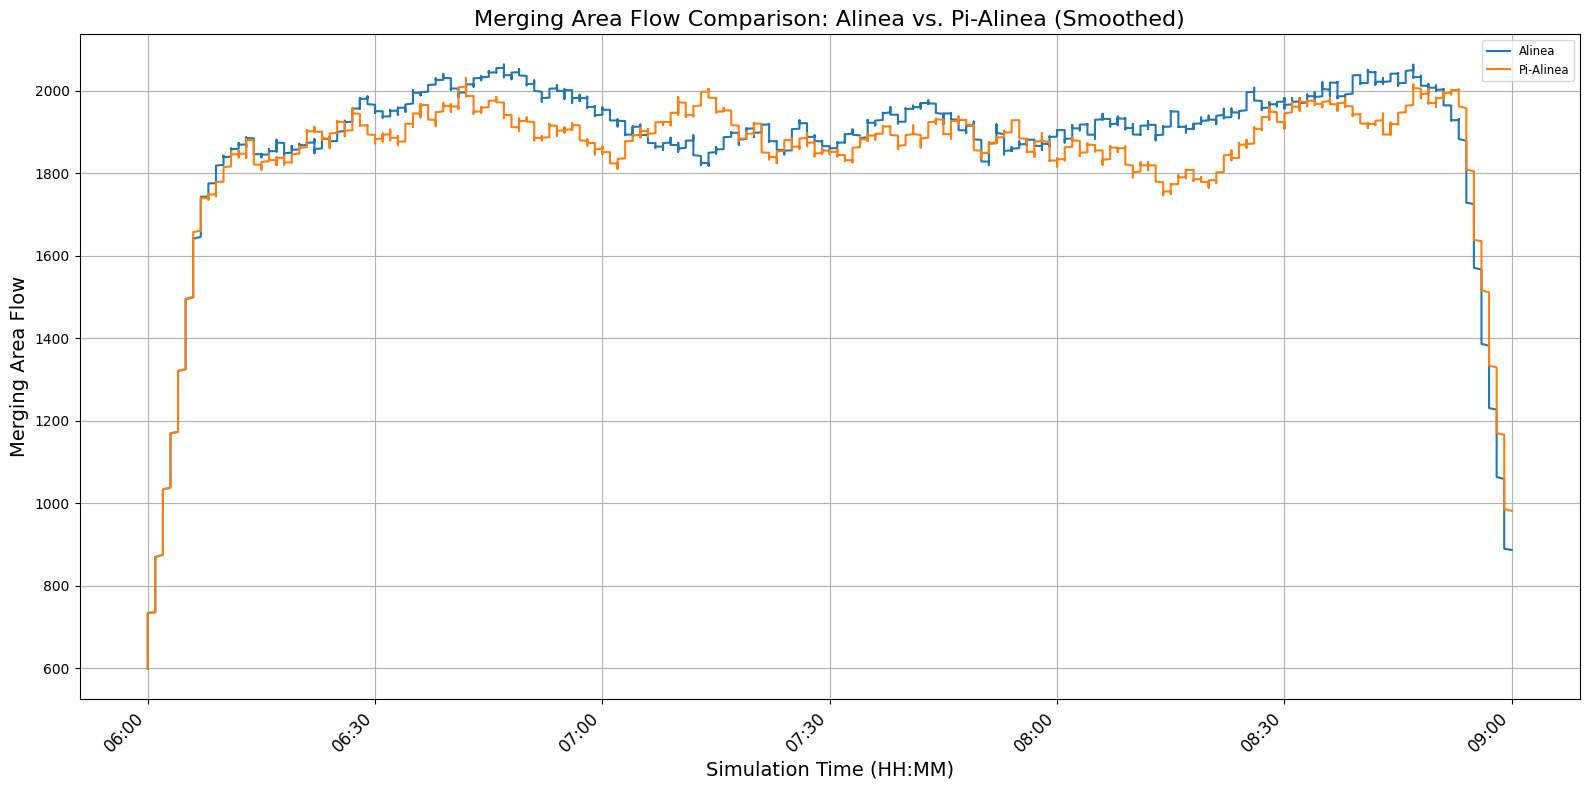

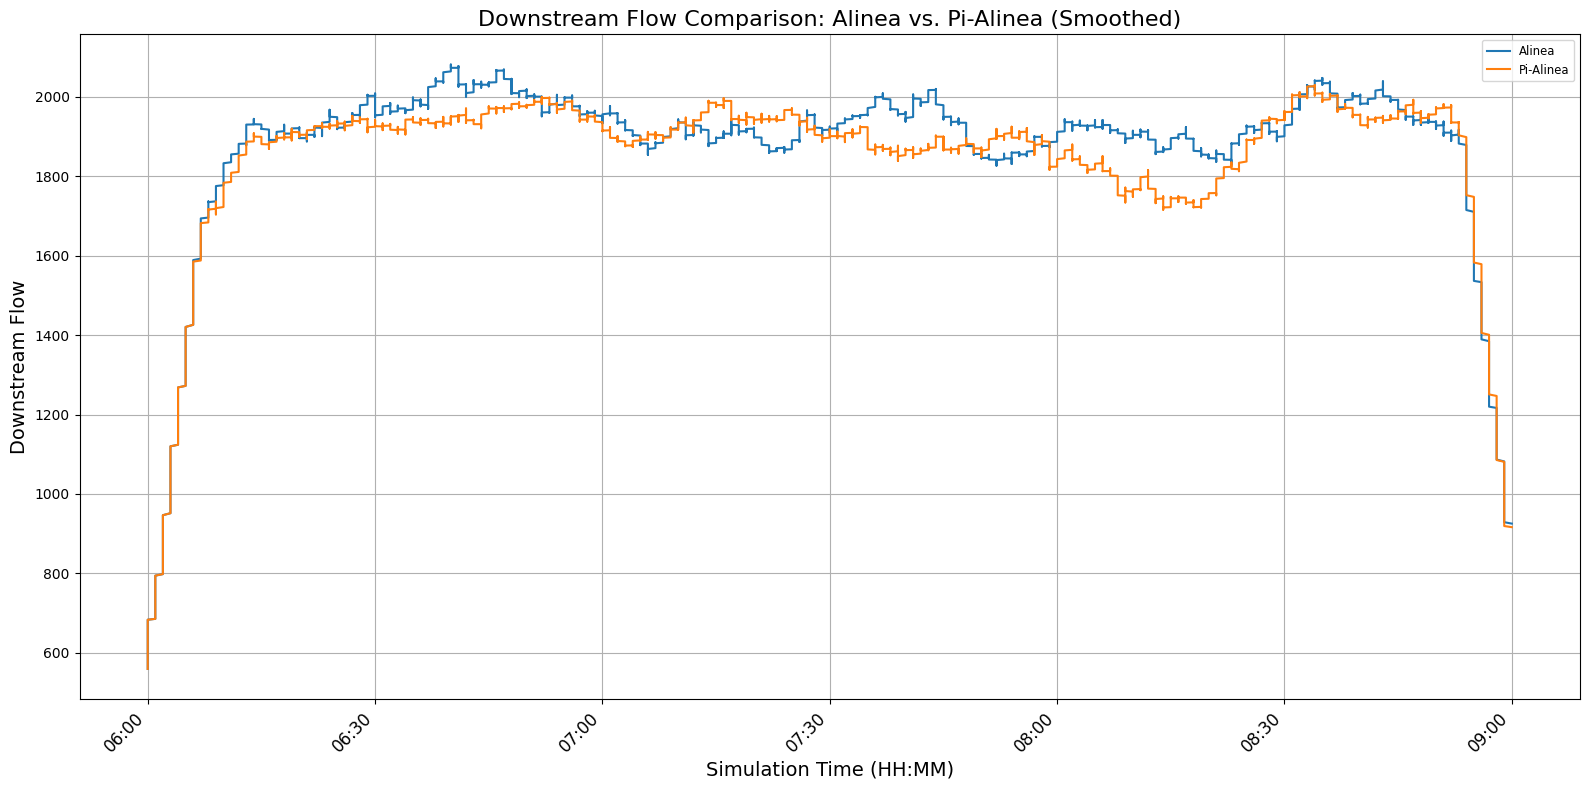

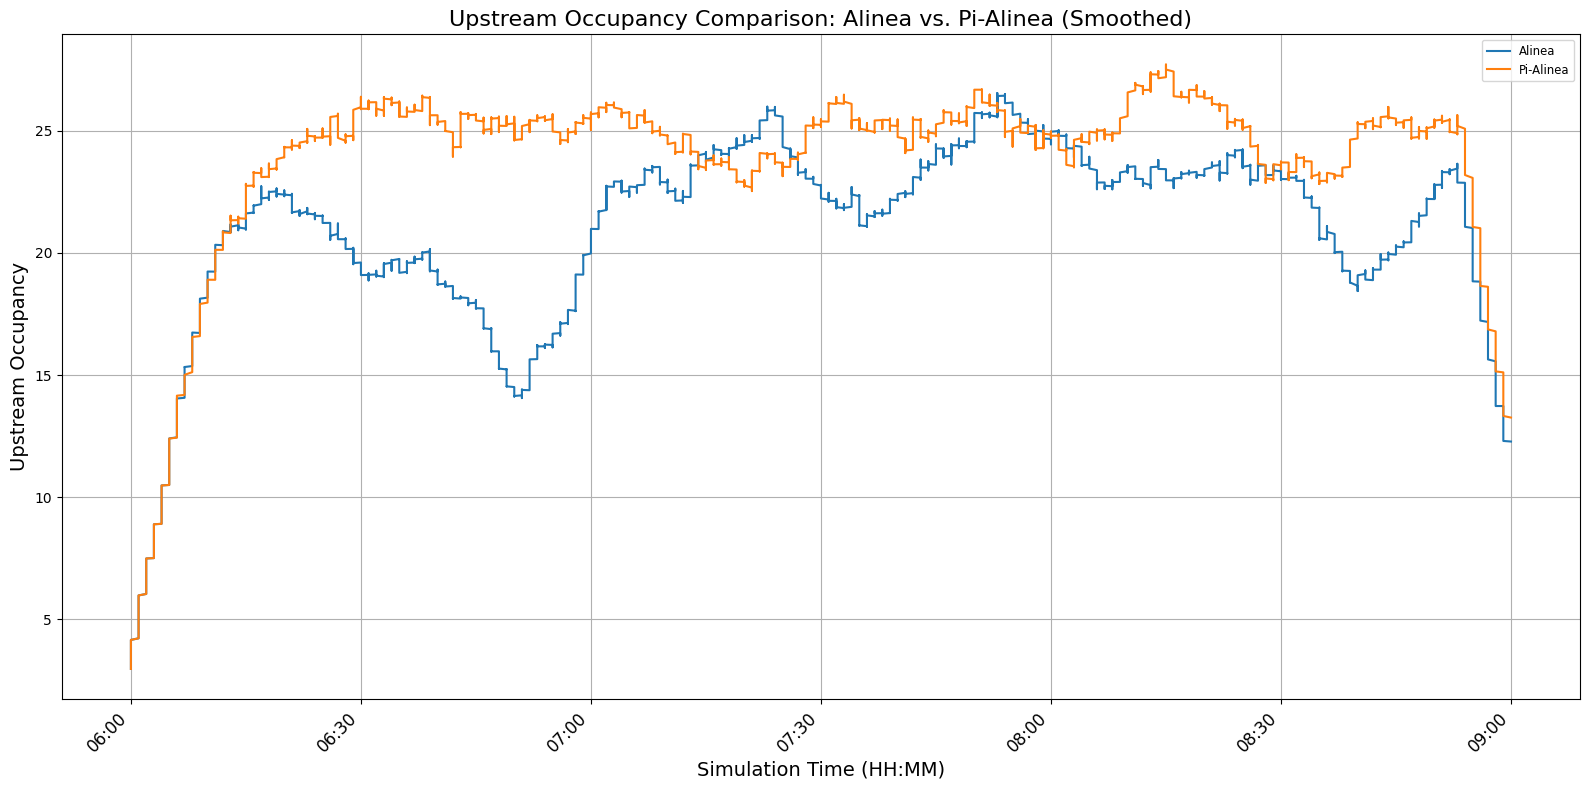

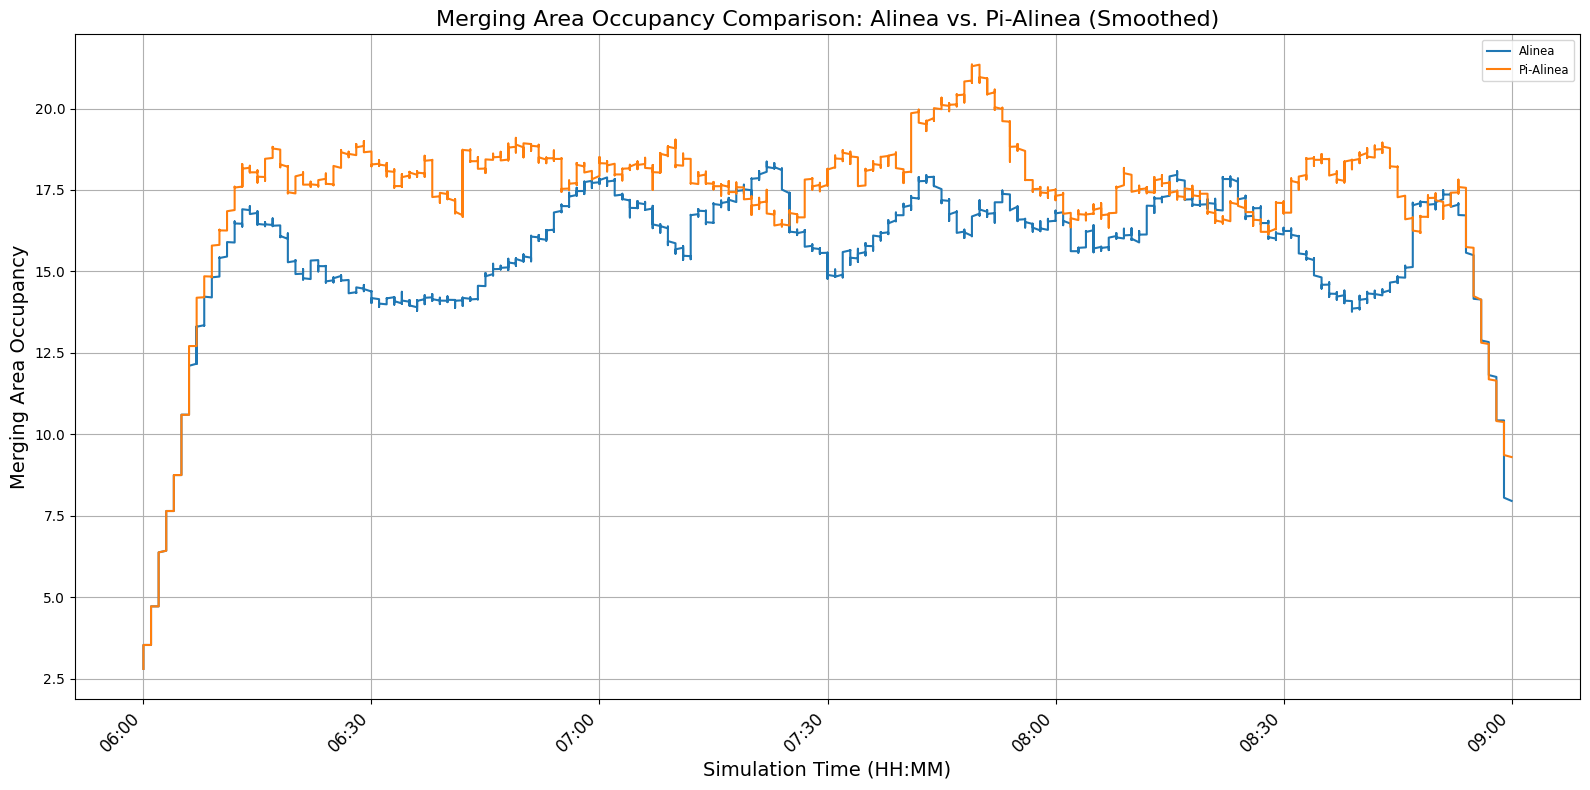

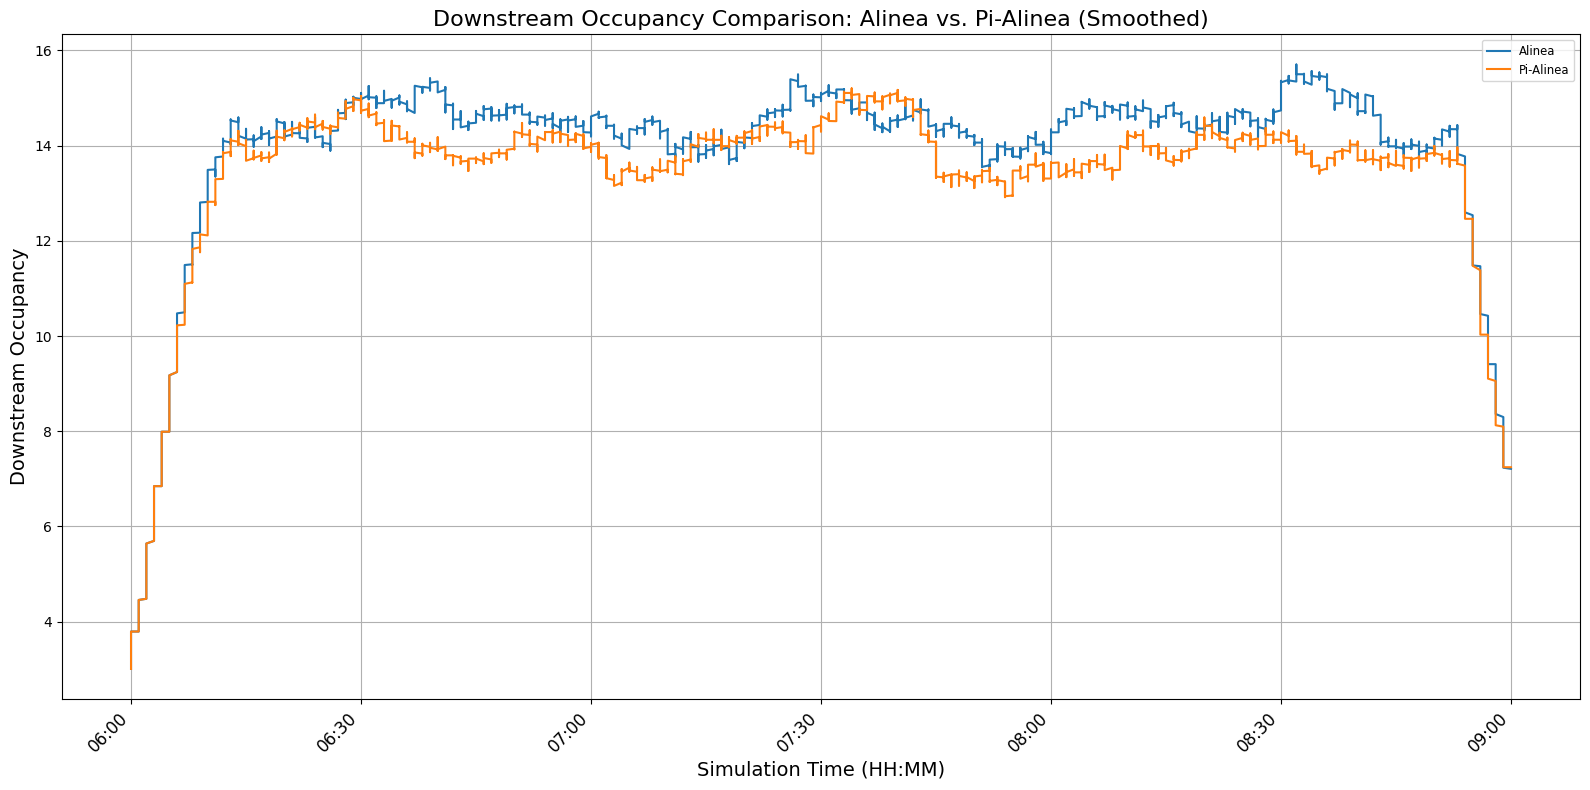

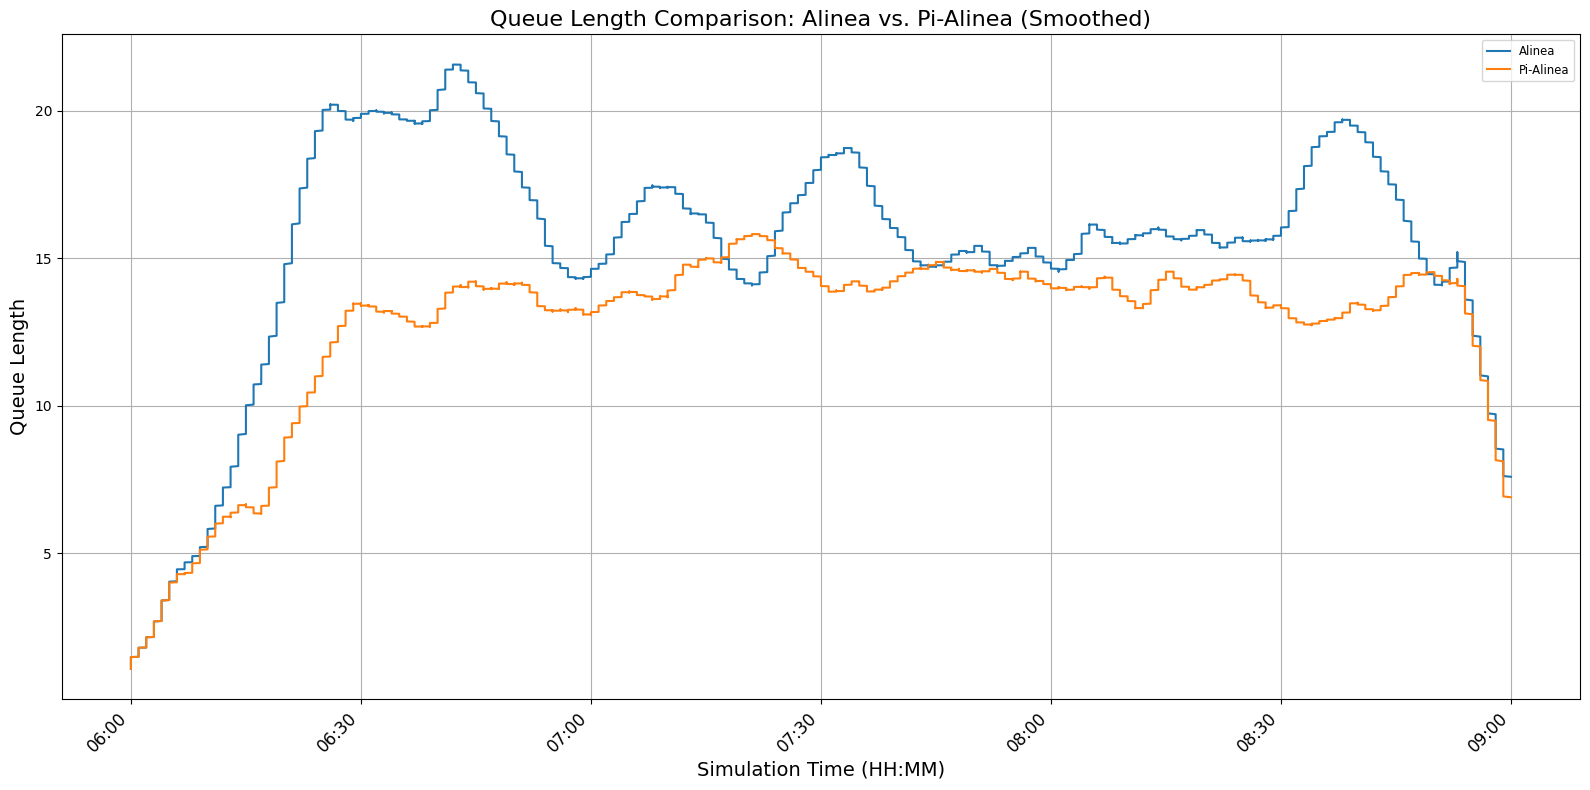

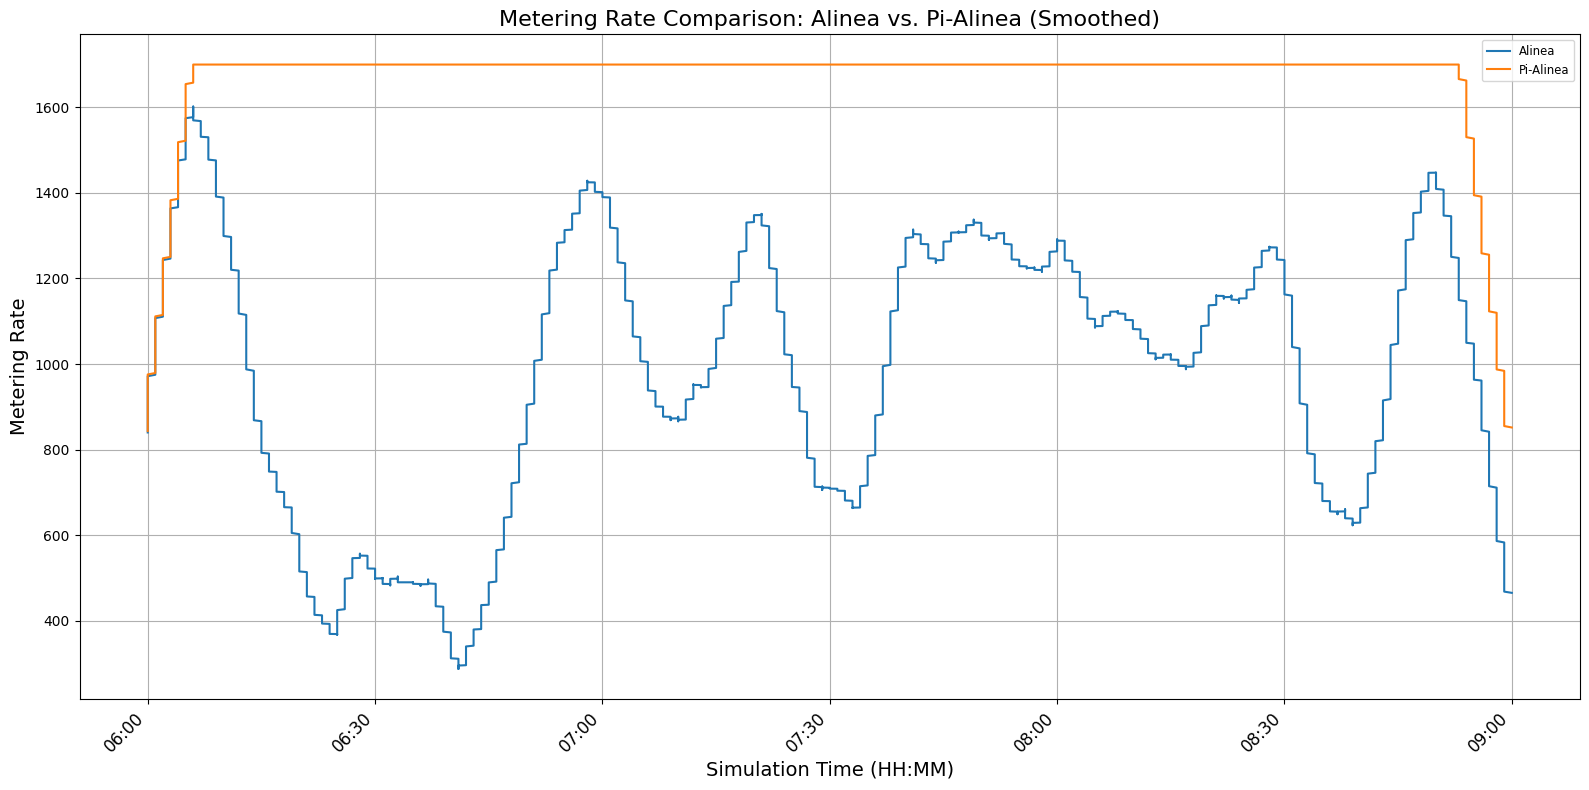

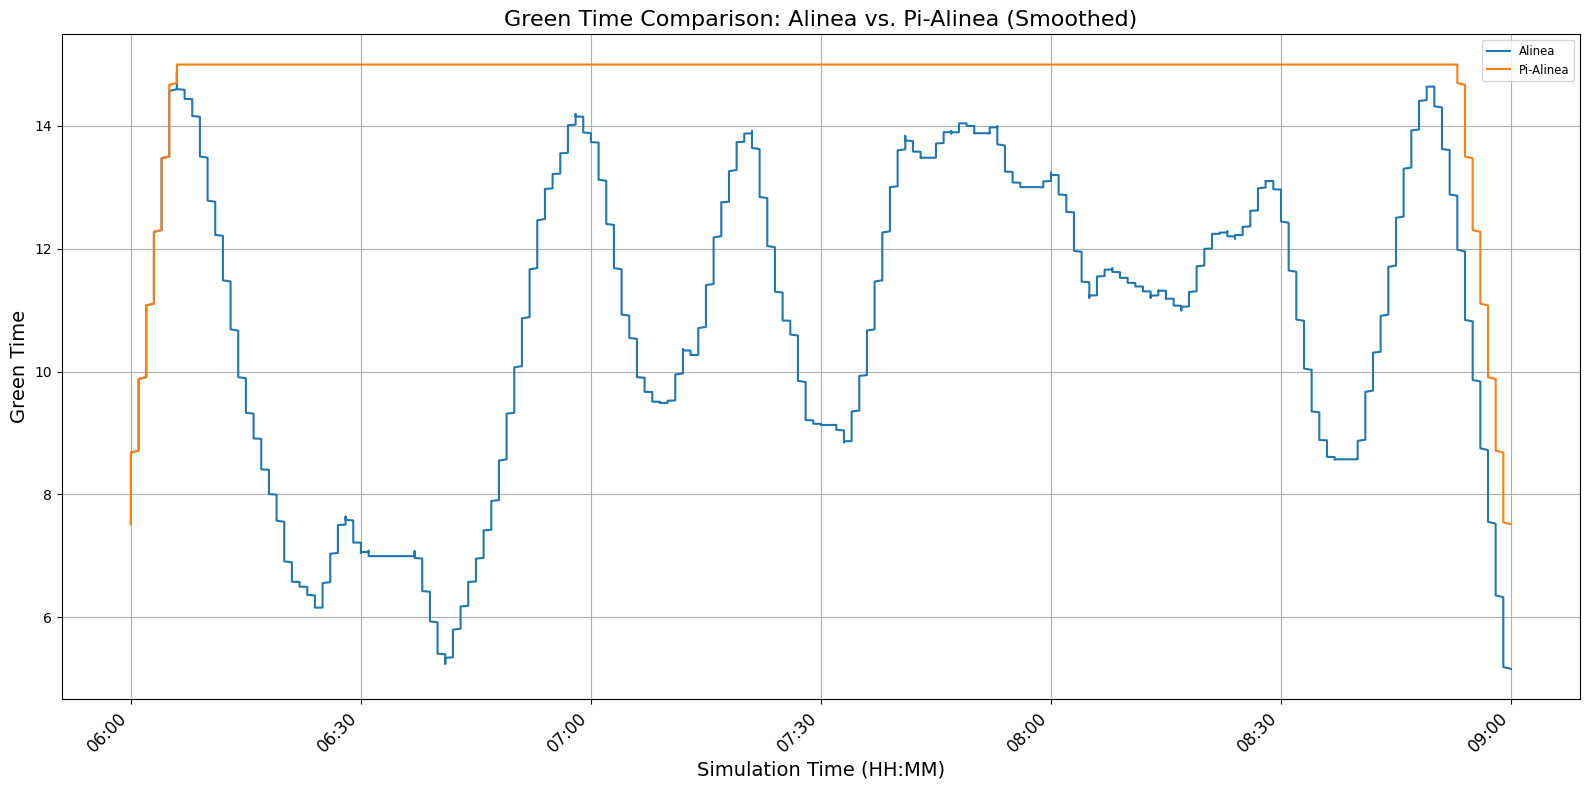

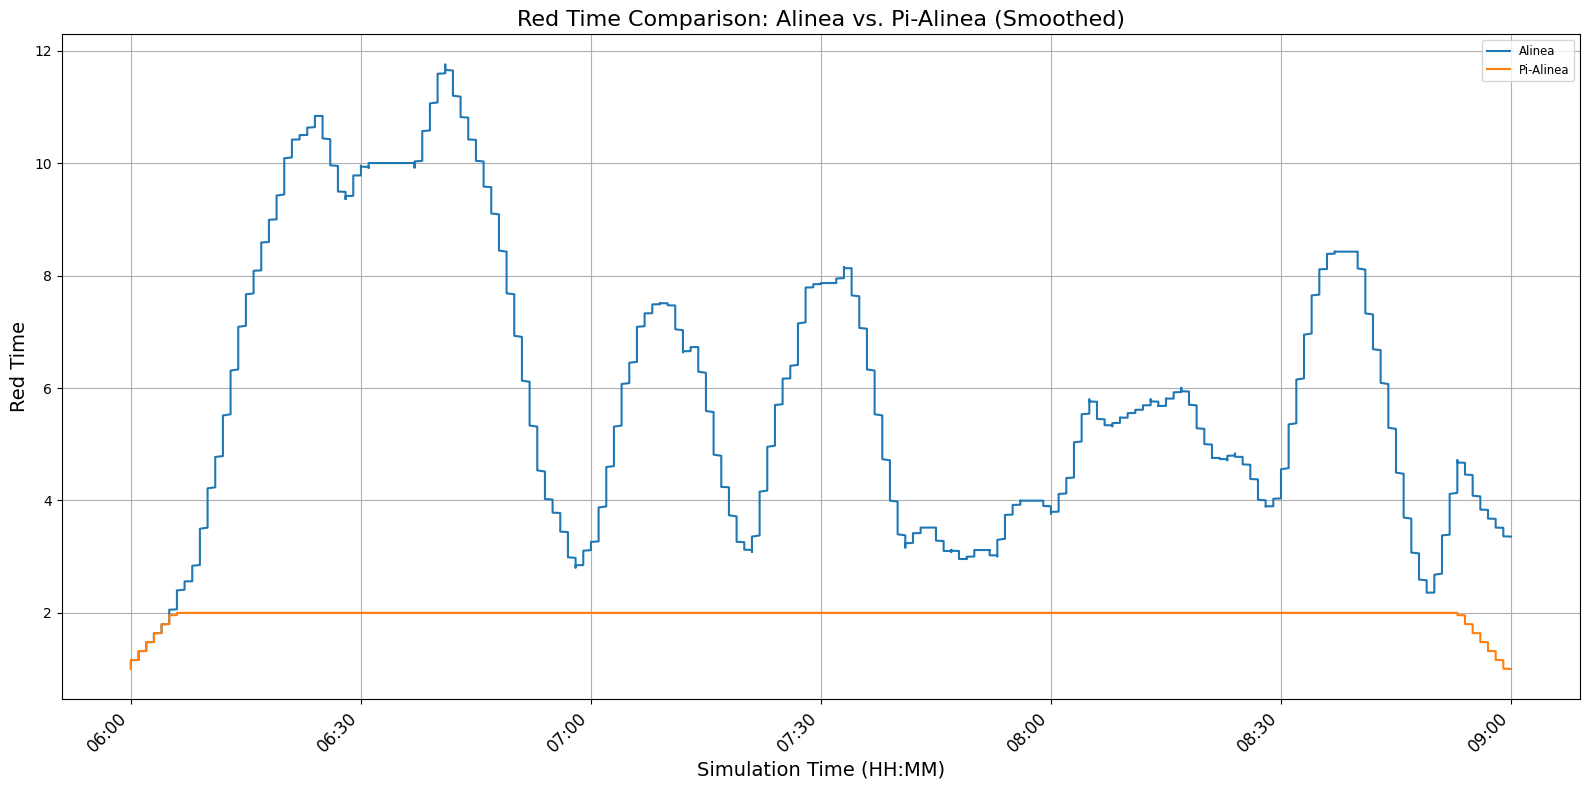

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import os


output_dir = 'plots_step'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


file_paths = {
    'deactivated': 'deactivated_log.csv',
    'alinea': 'alinea_log.csv',
    'MultPerGreen': 'MultPerGreen_log.csv',
    'OnePerGreen': 'OnePerGreen_log.csv',
    'pi-alinea': 'pi-alinea_log.csv'
}


features_all = [  "Upstream Flow",
    "Merging Area Flow",
    "Downstream Flow",
    "Upstream Occupancy",
    "Merging Area Occupancy",
    "Downstream Occupancy",
    "Queue Length"]


features_alinea = ["Upstream Flow",
    "Merging Area Flow",
    "Downstream Flow",
    "Upstream Occupancy",
    "Merging Area Occupancy",
    "Downstream Occupancy",
    "Queue Length", 'Metering Rate', 'Green Time', 'Red Time']


def time_from_step(step, max_step, total_simulation_time=3*3600, start_time_hour=6):
    """
    Converts step number to a time string (HH:MM) representing simulation time.
    Assumes 0 to total_simulation_time (seconds) corresponds to the entire simulation.
    """
    time_in_seconds = (step / max_step) * total_simulation_time
    hours = int(time_in_seconds // 3600) + start_time_hour
    minutes = int((time_in_seconds % 3600) // 60)
    return f"{hours:02}:{minutes:02}"


data = {}
max_step = 0
for strategy, path in file_paths.items():
    try:
        data[strategy] = pd.read_csv(path)
        max_step = max(max_step, data[strategy]['Step'].max())
    except FileNotFoundError:
        print(f"Error: File not found for strategy {strategy}")
        data[strategy] = None

# time labels using the maximum step
# Calculate time labels for every 15 minutes
total_simulation_time = 3 * 3600  # Total simulation time in seconds
start_time_hour = 6  # Start time hour
#num_time_labels = int(total_simulation_time / (15 * 60)) + 1  # Number of 15-minute intervals + 1
#time_labels = [time_from_step(i * (max_step / num_time_labels), max_step, total_simulation_time, start_time_hour) for i in range(num_time_labels)]


def smooth_data(y, window_size):
    """Applies a moving average smoothing filter to the data."""
    if len(y) < window_size:
        return y  # Return original data if shorter than window
    window = np.ones(window_size) / window_size
    y_smoothed = np.convolve(y, window, mode='same')
    return y_smoothed


smoothing_window = 501

for feature in features_all:
    plt.figure(figsize=(16, 8)) # Increased figure size
    plt.title(f'{feature} Comparison Across Strategies (Smoothed)', fontsize=16)
    plt.xlabel('Simulation Time (HH:MM)', fontsize=14)
    plt.ylabel(feature, fontsize=14)

    for strategy, df in data.items():
        if df is not None:
            # Create time labels based on the actual step values
            time_labels = [time_from_step(step, max_step) for step in df['Step']]

            # Apply smoothing to the feature data
            y_smoothed = smooth_data(df[feature], smoothing_window)

            plt.plot(time_labels, y_smoothed, label=strategy)

    # Generate 15-minute interval time labels for the x-axis
    start_time = 6 * 3600  # Start time in seconds
    end_time = start_time + 3 * 3600  # End time in seconds
    time_ticks = np.arange(start_time, end_time + 1, 15 * 60)  # 15-minute intervals in seconds
    time_labels_15min = [time_from_step(step * (max_step / (3*3600)), max_step) for step in time_ticks - start_time]


    plt.xticks(time_labels_15min[::2], rotation=45, ha='right', fontsize=12)  # Use the generated 15-minute time labels, increased font
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{feature}_comparison_smoothed.png'))  # Save the smoothed plot in 'plots' folder
    plt.show()



# Comparative Plots for Alinea vs. Pi-Alinea 
if data['alinea'] is not None and data['pi-alinea'] is not None:
    for feature in features_alinea:
        plt.figure(figsize=(16, 8)) # Increased figure size
        plt.title(f'{feature} Comparison: Alinea vs. Pi-Alinea (Smoothed)', fontsize=16)
        plt.xlabel('Simulation Time (HH:MM)', fontsize=14)
        plt.ylabel(feature, fontsize=14)

        # Create time labels based on the actual step values for Alinea
        time_labels_alinea = [time_from_step(step, max_step) for step in data['alinea']['Step']]
        y_smoothed_alinea = smooth_data(data['alinea'][feature], smoothing_window)
        plt.plot(time_labels_alinea, y_smoothed_alinea, label='Alinea')

        # Create time labels based on the actual step values for Pi-Alinea
        time_labels_pialinea = [time_from_step(step, max_step) for step in data['pi-alinea']['Step']]
        y_smoothed_pialinea = smooth_data(data['pi-alinea'][feature], smoothing_window)
        plt.plot(time_labels_pialinea, y_smoothed_pialinea, label='Pi-Alinea')


        # Generate 15-minute interval time labels for the x-axis
        start_time = 6 * 3600  # Start time in seconds
        end_time = start_time + 3 * 3600  # End time in seconds
        time_ticks = np.arange(start_time, end_time + 1, 15 * 60)  # 15-minute intervals in seconds
        time_labels_15min = [time_from_step(step * (max_step / (3*3600)), max_step) for step in time_ticks - start_time]



        plt.xticks(time_labels_15min[::2], rotation=45, ha='right', fontsize=12)  # Reduce x-axis label density, increased font
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{feature}_Alinea_vs_PiAlinea_smoothed.png'))
        plt.show()


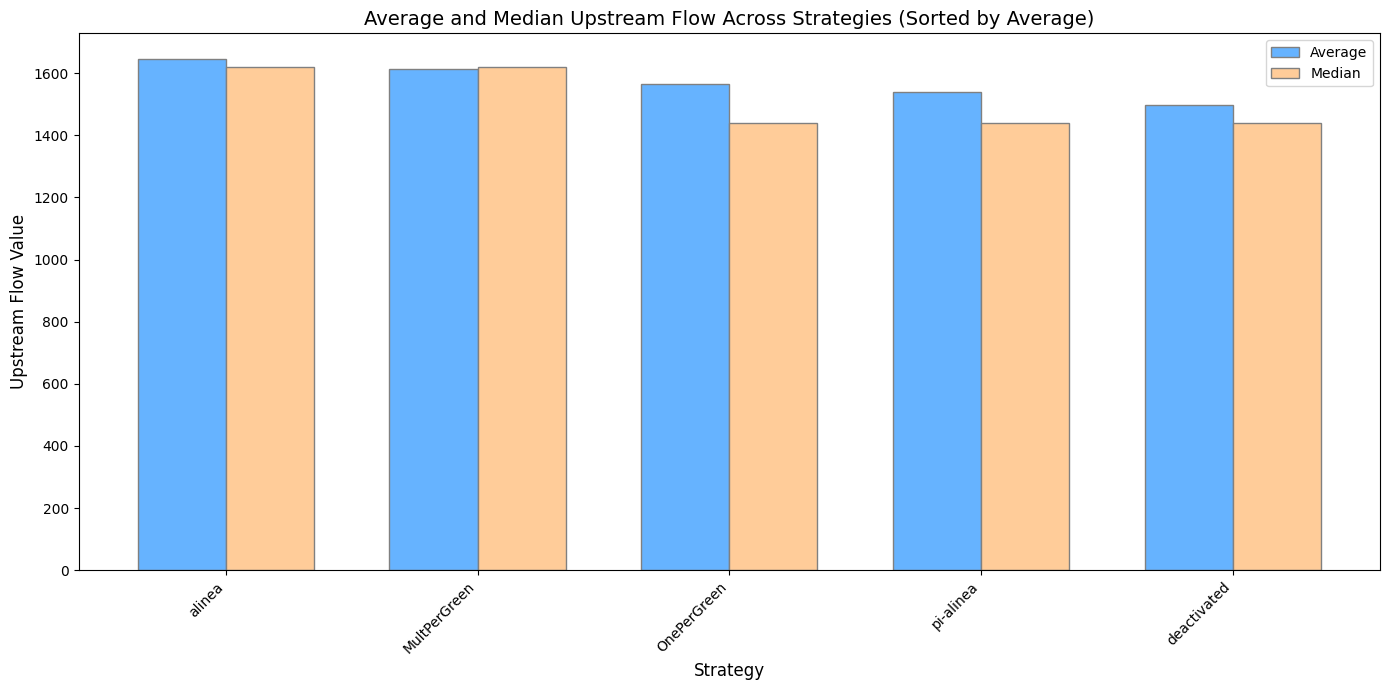

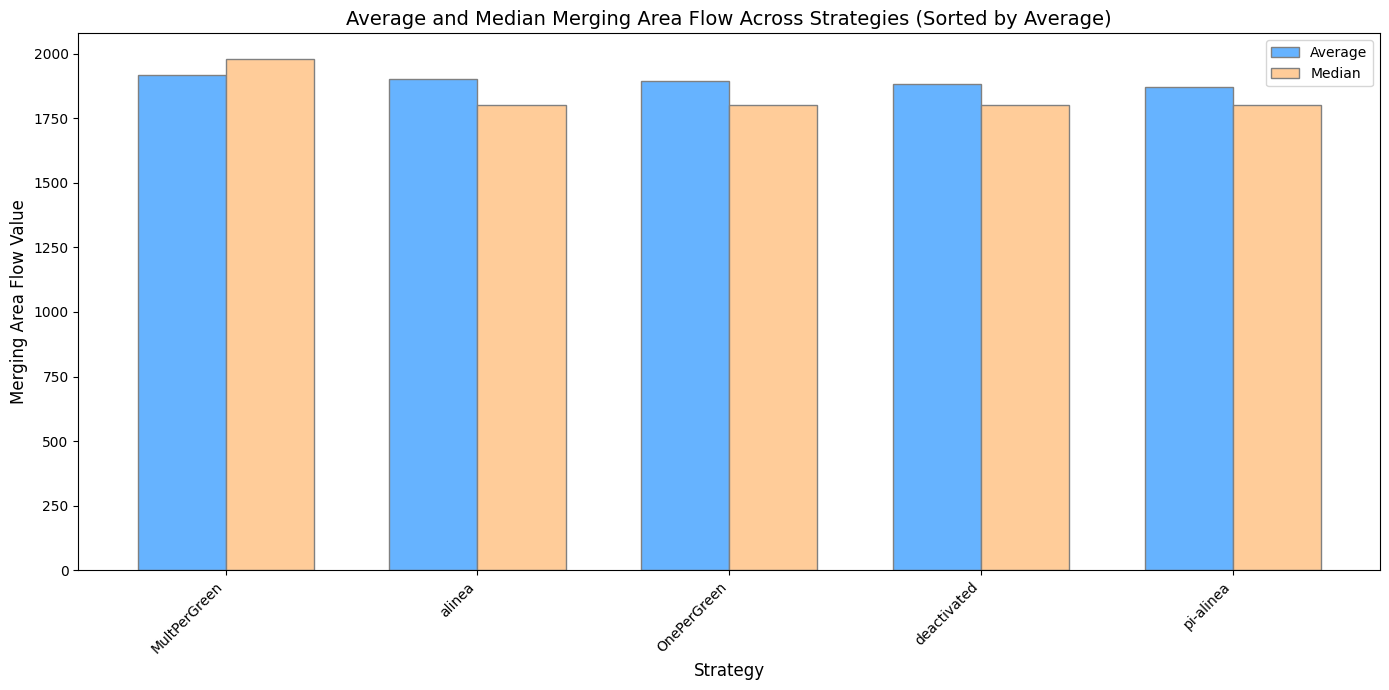

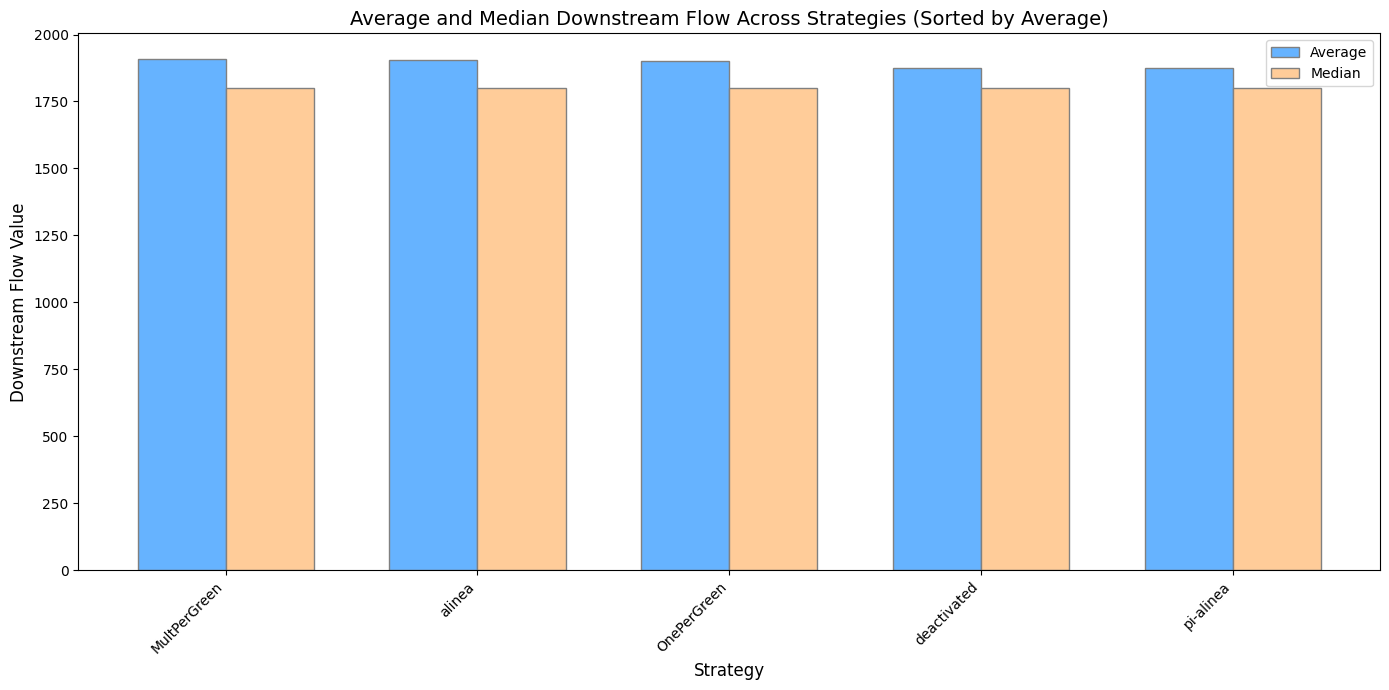

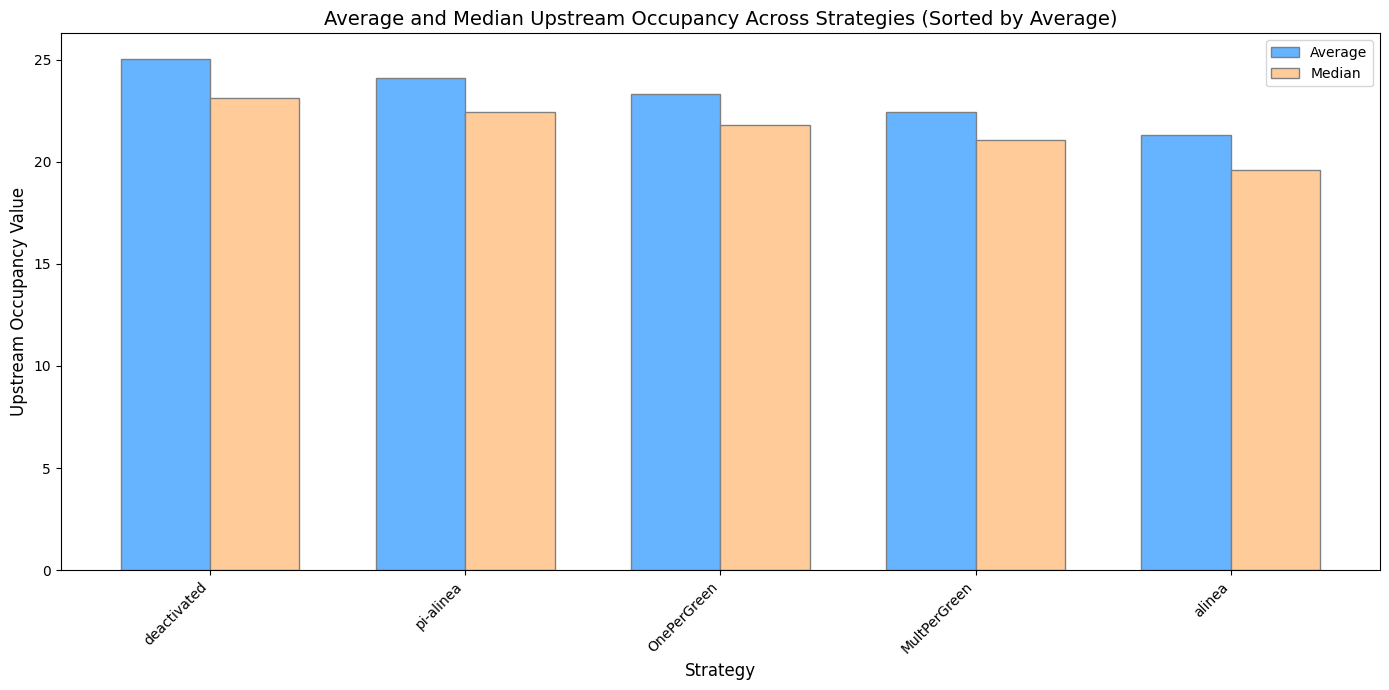

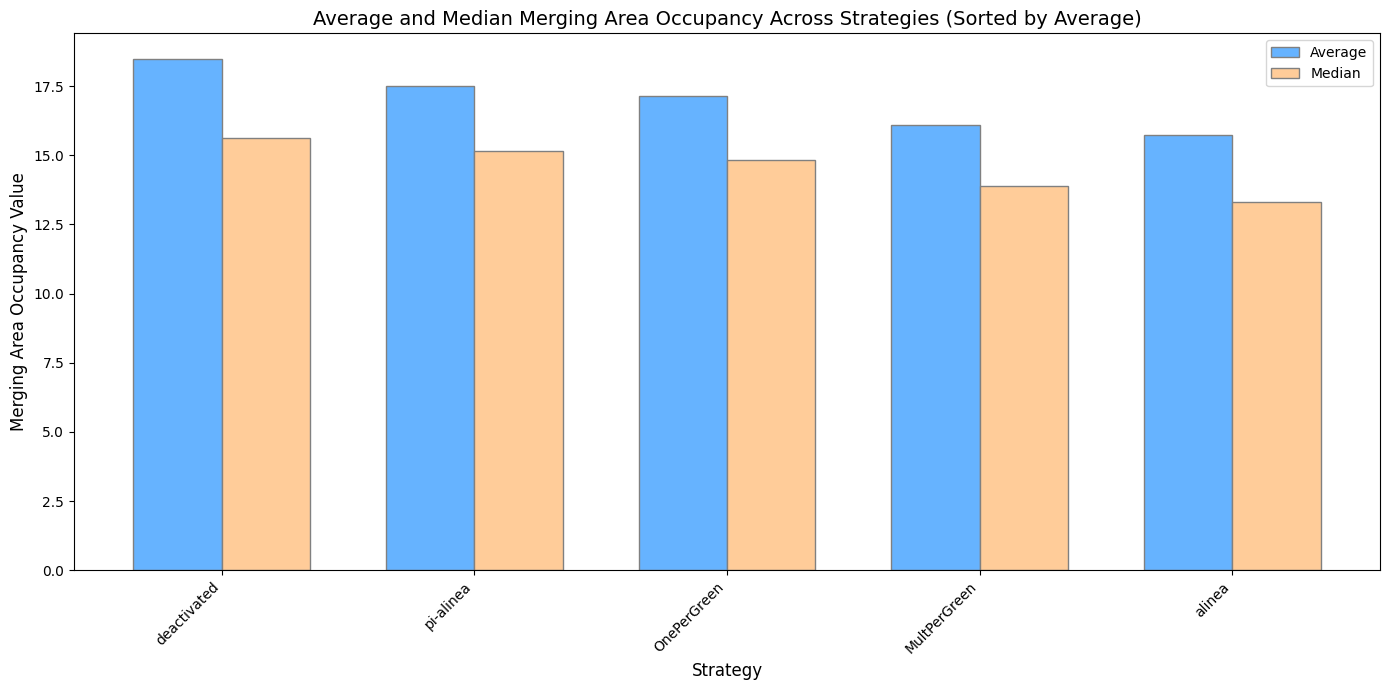

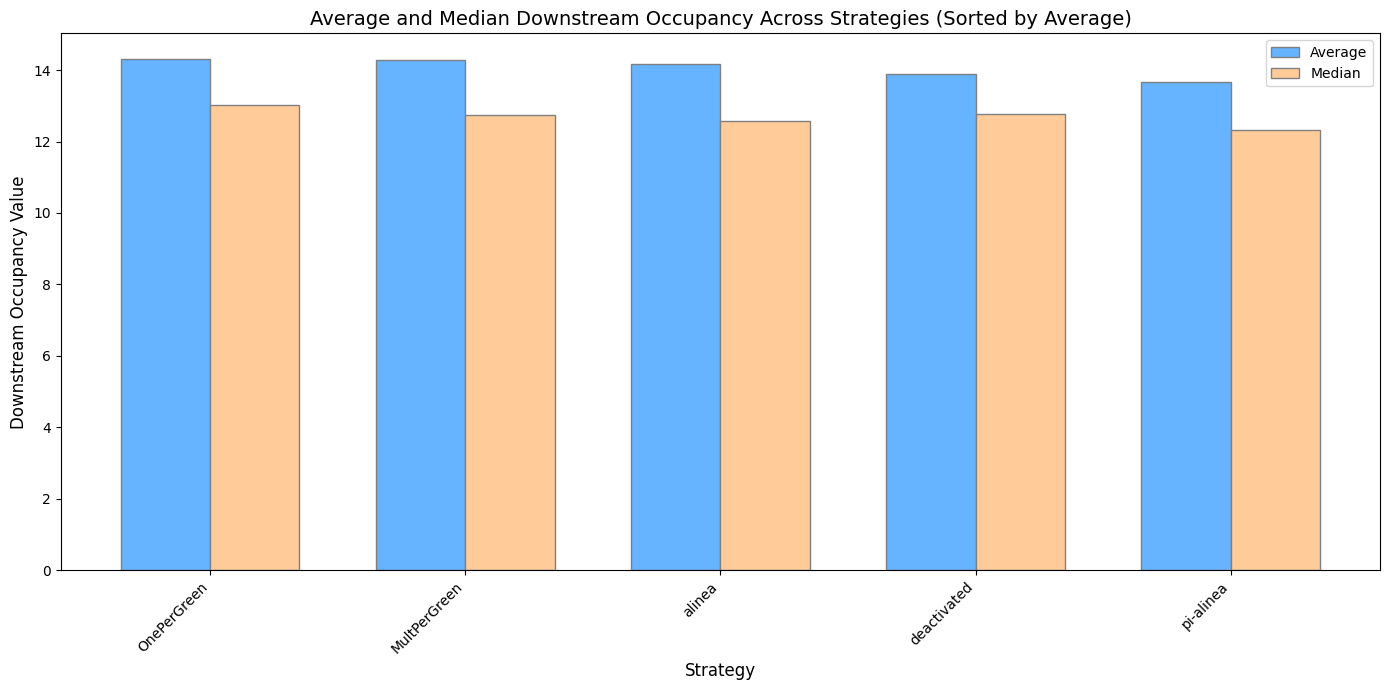

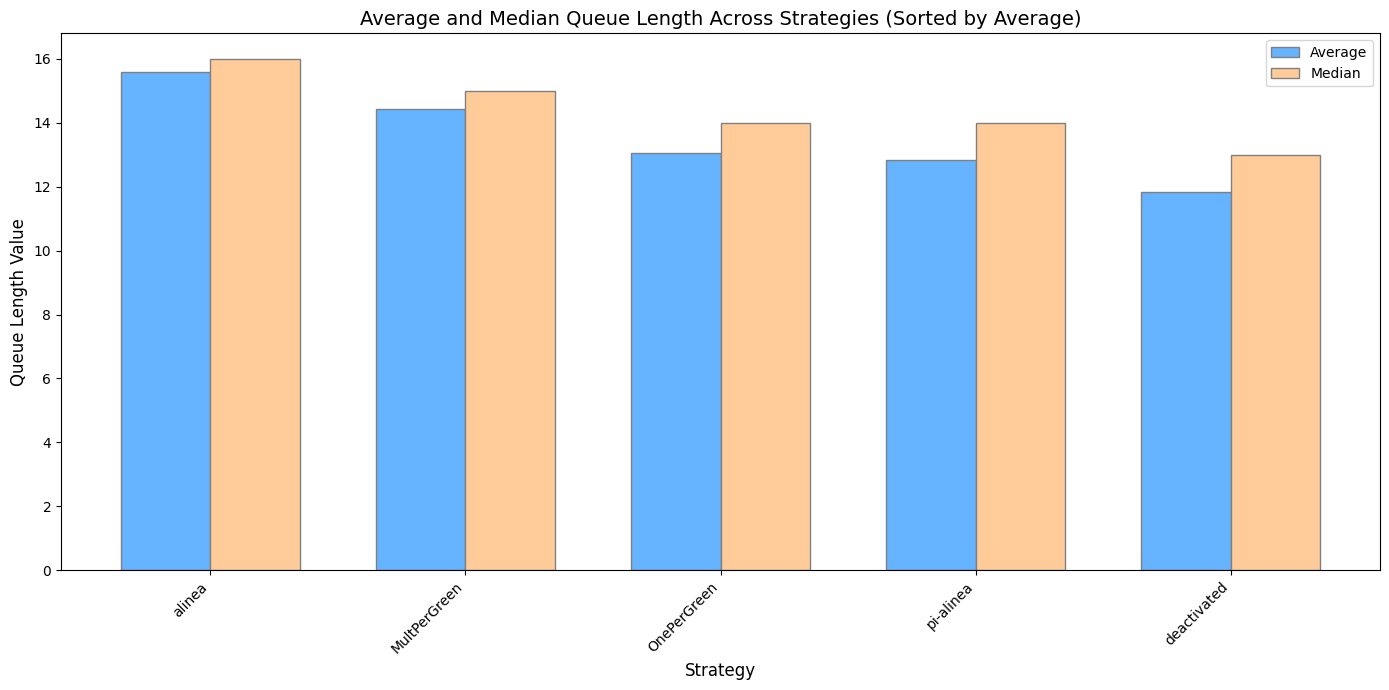

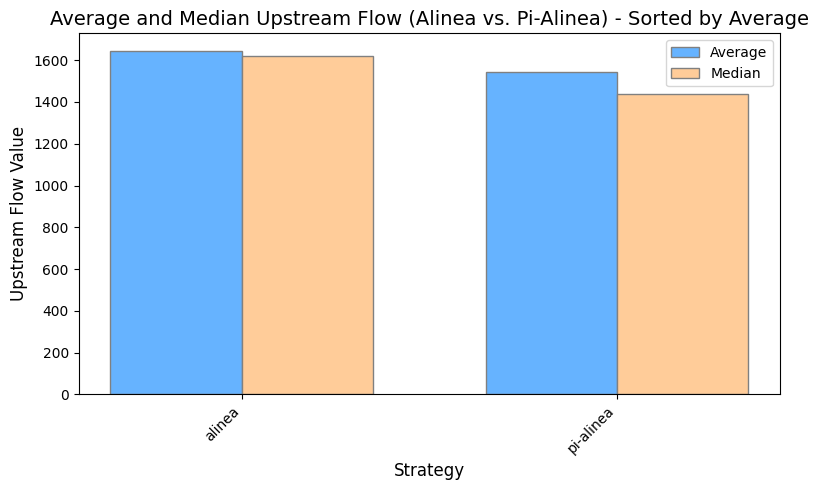

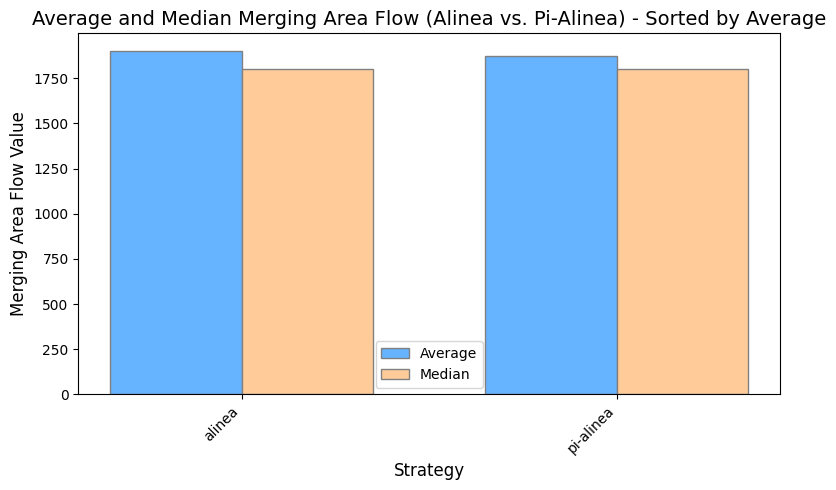

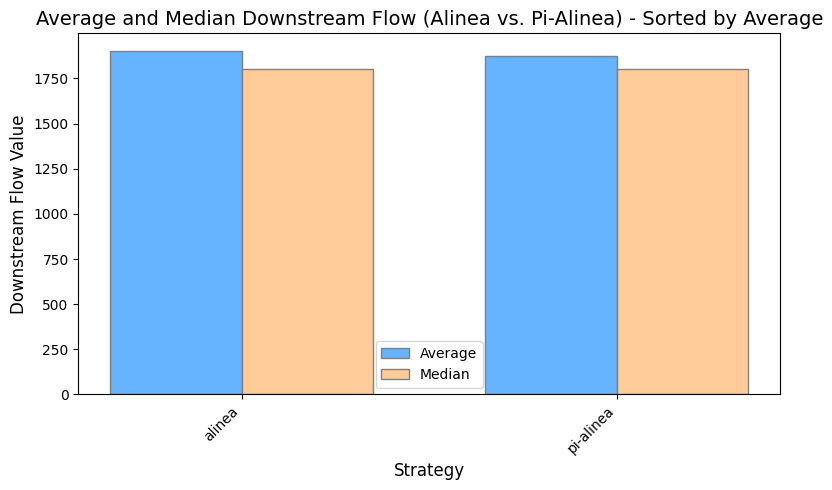

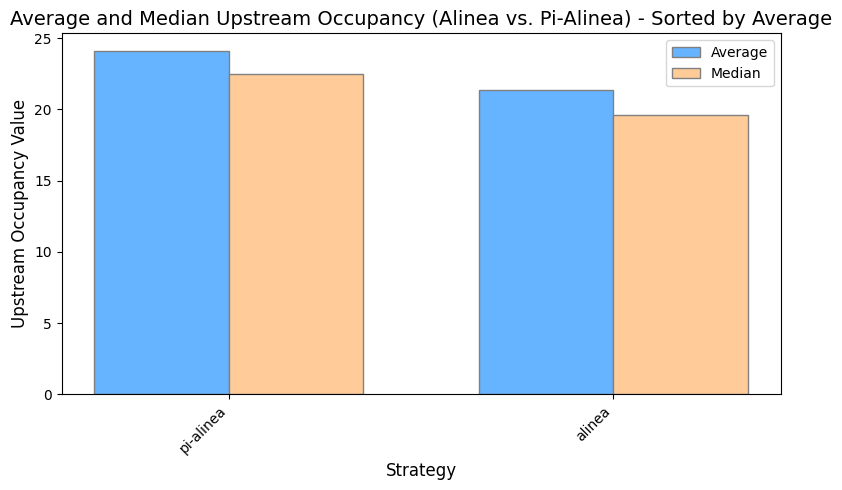

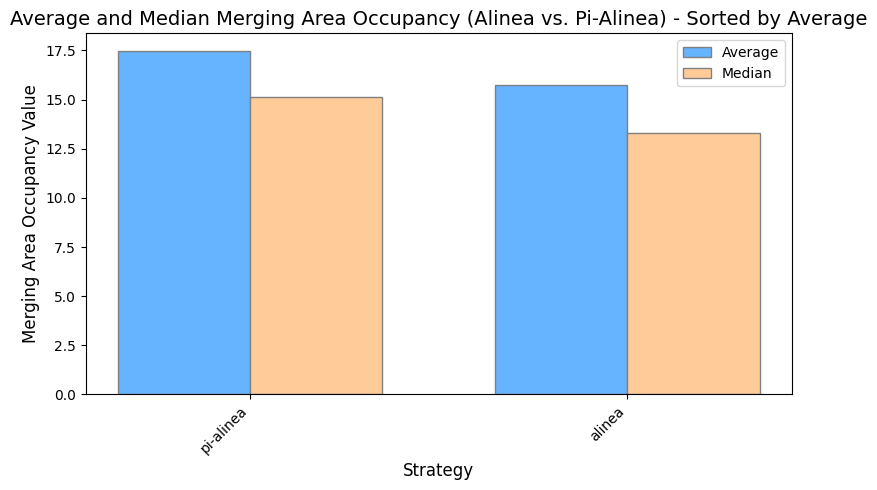

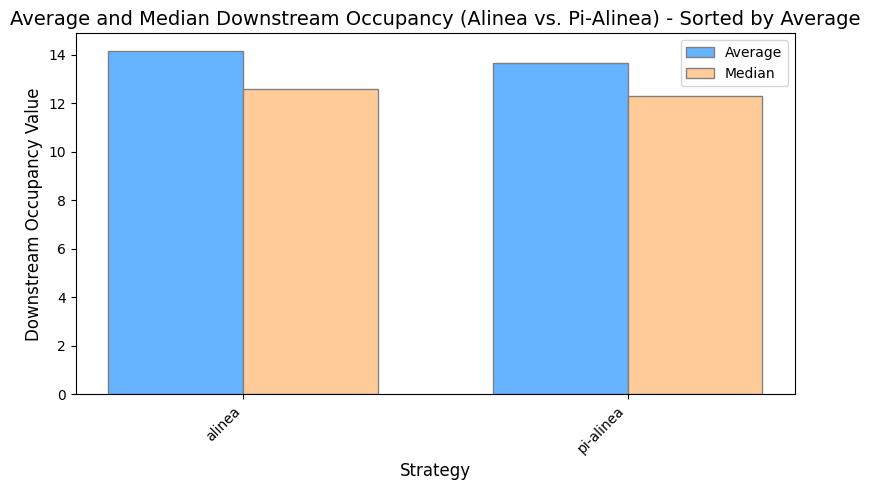

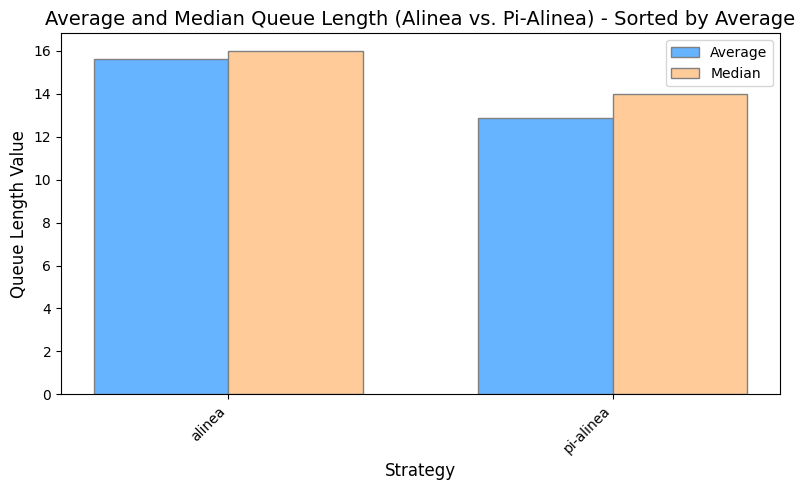

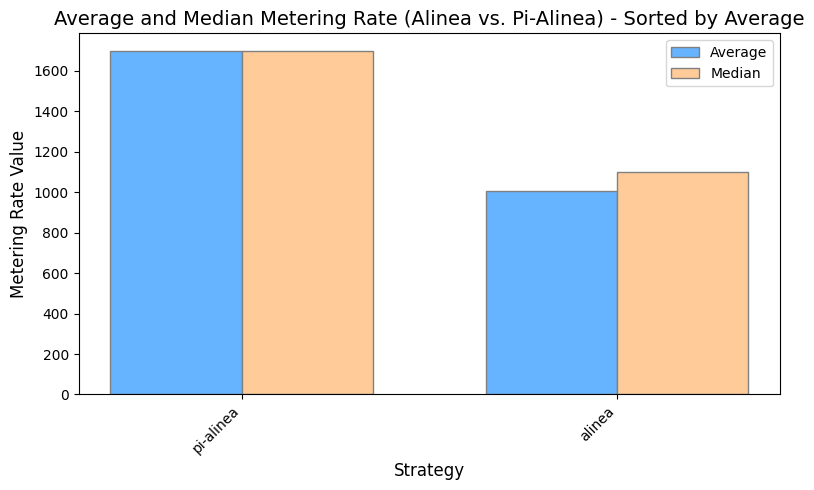

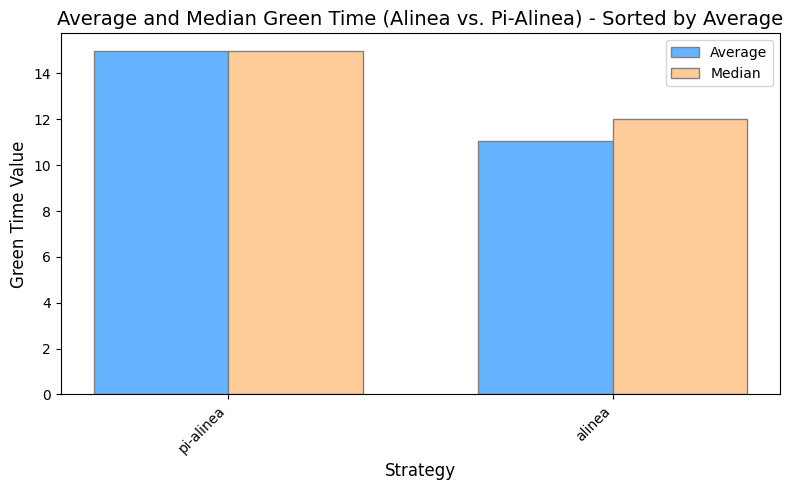

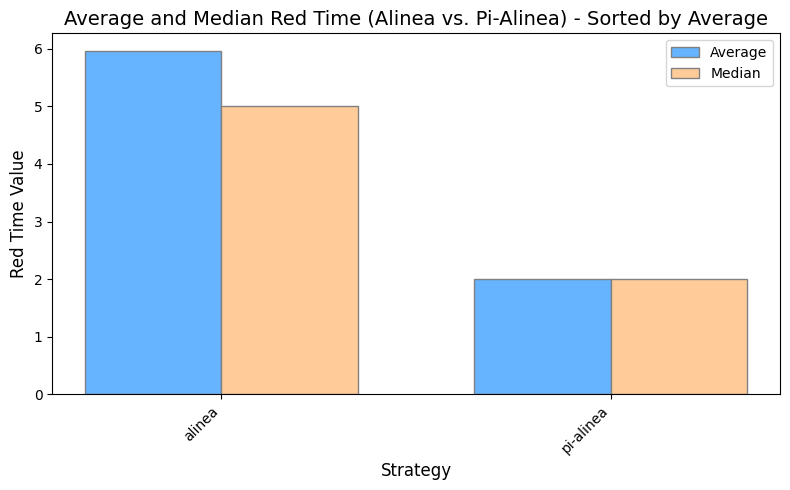

Average and Median Alinea vs Pi-Alinea plots generated successfully!
Plots generated successfully!


In [ ]:


smoothing_window = 1

#  Calculate and Plot Average and Median (All Strategies in a Single Sorted Plot) 

for feature in features_all:
    # Calculate Averages
    averages = {}
    for strategy, df in data.items():
        if df is not None:
            averages[strategy] = df[feature].mean()  # Use the mean of the original data

    # Calculate Medians
    medians = {}
    for strategy, df in data.items():
        if df is not None:
            medians[strategy] = df[feature].median()  # Use the median of the original data


    # Sort by average value (descending)
    sorted_strategies = sorted(averages, key=averages.get, reverse=True)
    sorted_averages = {k: averages[k] for k in sorted_strategies}
    sorted_medians = {k: medians[k] for k in sorted_strategies}

    
    bar_width = 0.35

    # Set positions of the bars on the x-axis
    r1 = np.arange(len(averages))
    r2 = [x + bar_width for x in r1]

    # Create the bar plot
    plt.figure(figsize=(14, 7))  
    plt.bar(r1, sorted_averages.values(), color='#66b3ff', width=bar_width, edgecolor='grey', label='Average')  # Light blue
    plt.bar(r2, sorted_medians.values(), color='#ffcc99', width=bar_width, edgecolor='grey', label='Median')  # Light orange

    # Add labels, title, and custom x-axis tick labels
    plt.xlabel('Strategy', fontsize=12)
    plt.ylabel(f'{feature} Value', fontsize=12)
    plt.title(f'Average and Median {feature} Across Strategies (Sorted by Average)', fontsize=14)
    plt.xticks([r + bar_width/2 for r in range(len(averages))], sorted_strategies, rotation=45, ha='right') # Rotate labels
    plt.legend()

    plt.tight_layout()  
    plt.savefig(os.path.join(output_dir, f'average_median_{feature}_comparison_sorted.png'))
    plt.show()


if data['alinea'] is not None and data['pi-alinea'] is not None:
    for feature in features_alinea:
        # Calculate Averages
        averages = {}
        averages['alinea'] = data['alinea'][feature].mean()
        averages['pi-alinea'] = data['pi-alinea'][feature].mean()

        # Calculate Medians
        medians = {}
        medians['alinea'] = data['alinea'][feature].median()
        medians['pi-alinea'] = data['pi-alinea'][feature].median()

        # Sort by average value (descending)
        sorted_strategies = sorted(averages, key=averages.get, reverse=True)
        sorted_averages = {k: averages[k] for k in sorted_strategies}
        sorted_medians = {k: medians[k] for k in sorted_strategies}

        # Bar width
        bar_width = 0.35

        # Set positions of the bars on the x-axis
        r1 = np.arange(len(averages))
        r2 = [x + bar_width for x in r1]

        # Create the bar plot
        plt.figure(figsize=(8, 5))  # Increased figure size for better label visibility
        plt.bar(r1, sorted_averages.values(), color='#66b3ff', width=bar_width, edgecolor='grey', label='Average')  # Light blue
        plt.bar(r2, sorted_medians.values(), color='#ffcc99', width=bar_width, edgecolor='grey', label='Median')  # Light orange

        # Add labels, title, and custom x-axis tick labels
        plt.xlabel('Strategy', fontsize=12)
        plt.ylabel(f'{feature} Value', fontsize=12)
        plt.title(f'Average and Median {feature} (Alinea vs. Pi-Alinea) - Sorted by Average', fontsize=14)
        plt.xticks([r + bar_width/2 for r in range(len(averages))], sorted_strategies, rotation=45, ha='right') # Rotate labels
        plt.legend()

        plt.tight_layout()  
        plt.savefig(os.path.join(output_dir, f'average_median_{feature}_Alinea_vs_PiAlinea_sorted.png'))
        plt.show()

print("Average and Median Alinea vs Pi-Alinea plots generated successfully!")

print("Plots generated successfully!")